## Import

In [2]:
import pandas as pd
import numpy as np
import sys
import platform
import xgboost as xgb


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
# Metrics & Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score, # Good overall metric for binary classification
    make_scorer,
)

# Ignore warnings (optional)
import warnings
warnings.filterwarnings('ignore')


## Loading Data (processed)

In [3]:
processed_file_path = '../data/processed/stroke_data_processed.csv'
df = pd.read_csv(processed_file_path)
print("Data loaded successfully.")
print("DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Data loaded successfully.
DataFrame shape: (5110, 17)
Columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,0,1,0


## Feature X & target y

In [4]:
X = df.drop('stroke', axis=1)
y = df['stroke']
print("Features (X) and Target (y) defined.")

Features (X) and Target (y) defined.


In [5]:
print("Splitting data into train and test sets (70/30 split, stratified)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Stroke distribution in y_train:\n", y_train.value_counts(normalize=True))
print("Stroke distribution in y_test:\n", y_test.value_counts(normalize=True))

Splitting data into train and test sets (70/30 split, stratified)...
Train set shape: (4088, 16) (4088,)
Test set shape: (1022, 16) (1022,)
Stroke distribution in y_train:
 stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Stroke distribution in y_test:
 stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


## Model training

Let's define how the model should interpret the data.  
Like 0 : negative and 1 : positive.  
0 -> No Stroke, 1 -> Stroke

In [6]:
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight_cv = neg_count / pos_count if pos_count > 0 else 1

We got a problem.  
Our model goodly predict who will haven't stroke, but very bad predict who will have stroke.  
(97% precision / 23% Precision)  
It's simply because we have so many data who haven't stroke, it's creating unbalanced distribution of our datas.

So to address this , we will use SMOTE (Synthetic Minority Over-Sampling Technique)  
It's a good technique to generate synthetic samples from the minority class (here, 'stroke' = 1), to balance the datas.

In [7]:
# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [8]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Assuming models are trained and stored in a dictionary
models = {
    "XGBoost": xgb_model,
    "RandomForest": rf_model,
    # Add other models here if needed
}

# Prepare a DataFrame to store metrics
metrics_summary = []



In [17]:
y_pred = models['RandomForest'].predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.9070450097847358
Precision: 0.16326530612244897
Recall: 0.12903225806451613
F1 Score: 0.14414414414414414
ROC AUC: 0.5431619623655913


In [13]:
# Calculate accuracy for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    metrics_summary.append({
        'Model': name,
        'Accuracy': accuracy
    })

# Convert to DataFrame
summary_df = pd.DataFrame(metrics_summary)

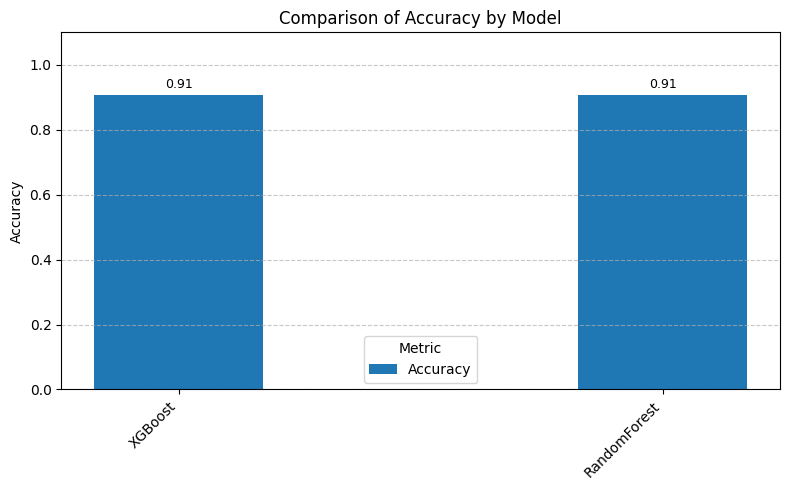

Accuracy plot generated.


In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(summary_df['Model']))  # positions for each model
width = 0.35  # width of the bars

# Bar colors
colors = ['#1f77b4']

# Create bars for accuracy
rects = ax.bar(x, summary_df['Accuracy'], width, label='Accuracy', color=colors[0])

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Model'], rotation=45, ha="right")
ax.legend(title="Metric")
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 1.1)

# Function to add labels above bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects)

fig.tight_layout()
plt.show()

print("Accuracy plot generated.")